# Inductive Venn-ABERS for Regression (IVAR)

This notebook demonstrates the use of a nove Inductive Venn-ABERS algorithm applied to regression problems and its cross validates-form (IVAR and CVAR respectively). As underlying datasets we use the Friedman datasets from sci-kit learn, which are known to be challenging for standard regression algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3 
from sklearn.svm import SVR

from venn_abers import VennAberRegressor

import random
import warnings

m_parameters = [1]

warnings.filterwarnings("ignore")

In [2]:
def generate_friedman_dataset(typ : int, n_samples: int, noise_scale: float= 1.0, random_state: int = 0, standardize:  bool = True):
    try:
        if typ == 1:
            X, y = make_friedman1(n_samples=n_samples, noise=noise_scale, random_state=random_state)
        elif typ == 2:
            X, y = make_friedman2(n_samples=n_samples, noise=noise_scale, random_state=random_state)
        else:
            X, y = make_friedman3(n_samples=n_samples, noise=noise_scale, random_state=random_state)              
    except:
        raise ValueError(f"Unknown dataset: {typ}")
            

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    if standardize:
        mu = X_train.mean(axis=0, keepdims=True)
        sig = X_train.std(axis=0, keepdims=True) + 1e-12
        X_train = (X_train - mu) / sig
        X_test = (X_test - mu) / sig

    return X_train, X_test, y_train, y_test

In [3]:
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def baseline_models(random_state: int = 0):
    return {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet(),
        "SVR(RBF)": SVR(),
        "RandomForest": RandomForestRegressor(random_state=random_state, n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingRegressor(random_state=random_state)
        
    }


def run_one_scenario(
    *,
    typ: int,
    n_samples: int = 10000,
    noise_scale: float = 1.0,
    seed: int = 0,
):
    X_train, X_test, y_train, y_test = generate_friedman_dataset(
        typ = typ,
        n_samples=n_samples,
        noise_scale=noise_scale,
        random_state=seed,
    )

    results = {}
    for name, model in baseline_models(random_state=seed).items():
        model.fit(X_train, y_train)
        base_pred =  model.predict(X_test)
        results[name] = rmse(y_test, base_pred)
        va = VennAberRegressor(estimator=model, inductive=False, n_splits=10, random_state=seed)
        for m in m_parameters:
                va.fit(X_train, y_train, m=m)
                va_preds, _ = va.predict(X_test)
                results[name + ' CVAP - ' + str(m)] = rmse(y_test, va_preds)

    return results

## Comparison with Least Squares Linear Regression

Here we generate an example of the Friedman 2 dataset and use Linear Regression as the underlying algorithm, on which we apply a Cross- version of Inductive Venn-ABERS for regression, using 10 folds. 

In [4]:
X_train, X_test, y_train, y_test = generate_friedman_dataset(
        typ = 2,
        n_samples=10000,
        noise_scale=3,
        random_state=0,
    )

In [5]:
results = dict()
model=LinearRegression()
model.fit(X_train, y_train)
base_pred =  model.predict(X_test)
results['base'] = rmse(y_test, base_pred)
va = VennAberRegressor(estimator=model, inductive=False, n_splits=10, random_state=0)
for m in m_parameters:
    va.fit(X_train, y_train, m=m)
    va_preds, va_interval = va.predict(X_test)
    results['CVAR - ' + str(m)] = rmse(y_test, va_preds)

In [6]:
results

{'base': 139.43806131186744, 'CVAR - 1': 84.42370304514303}

The results suggest that CVAR achieves a lower RMSE compared with standard Least Squares regression.

The plots below show the predicted vs, actual y values, together with the CVAR intervals for large y-values

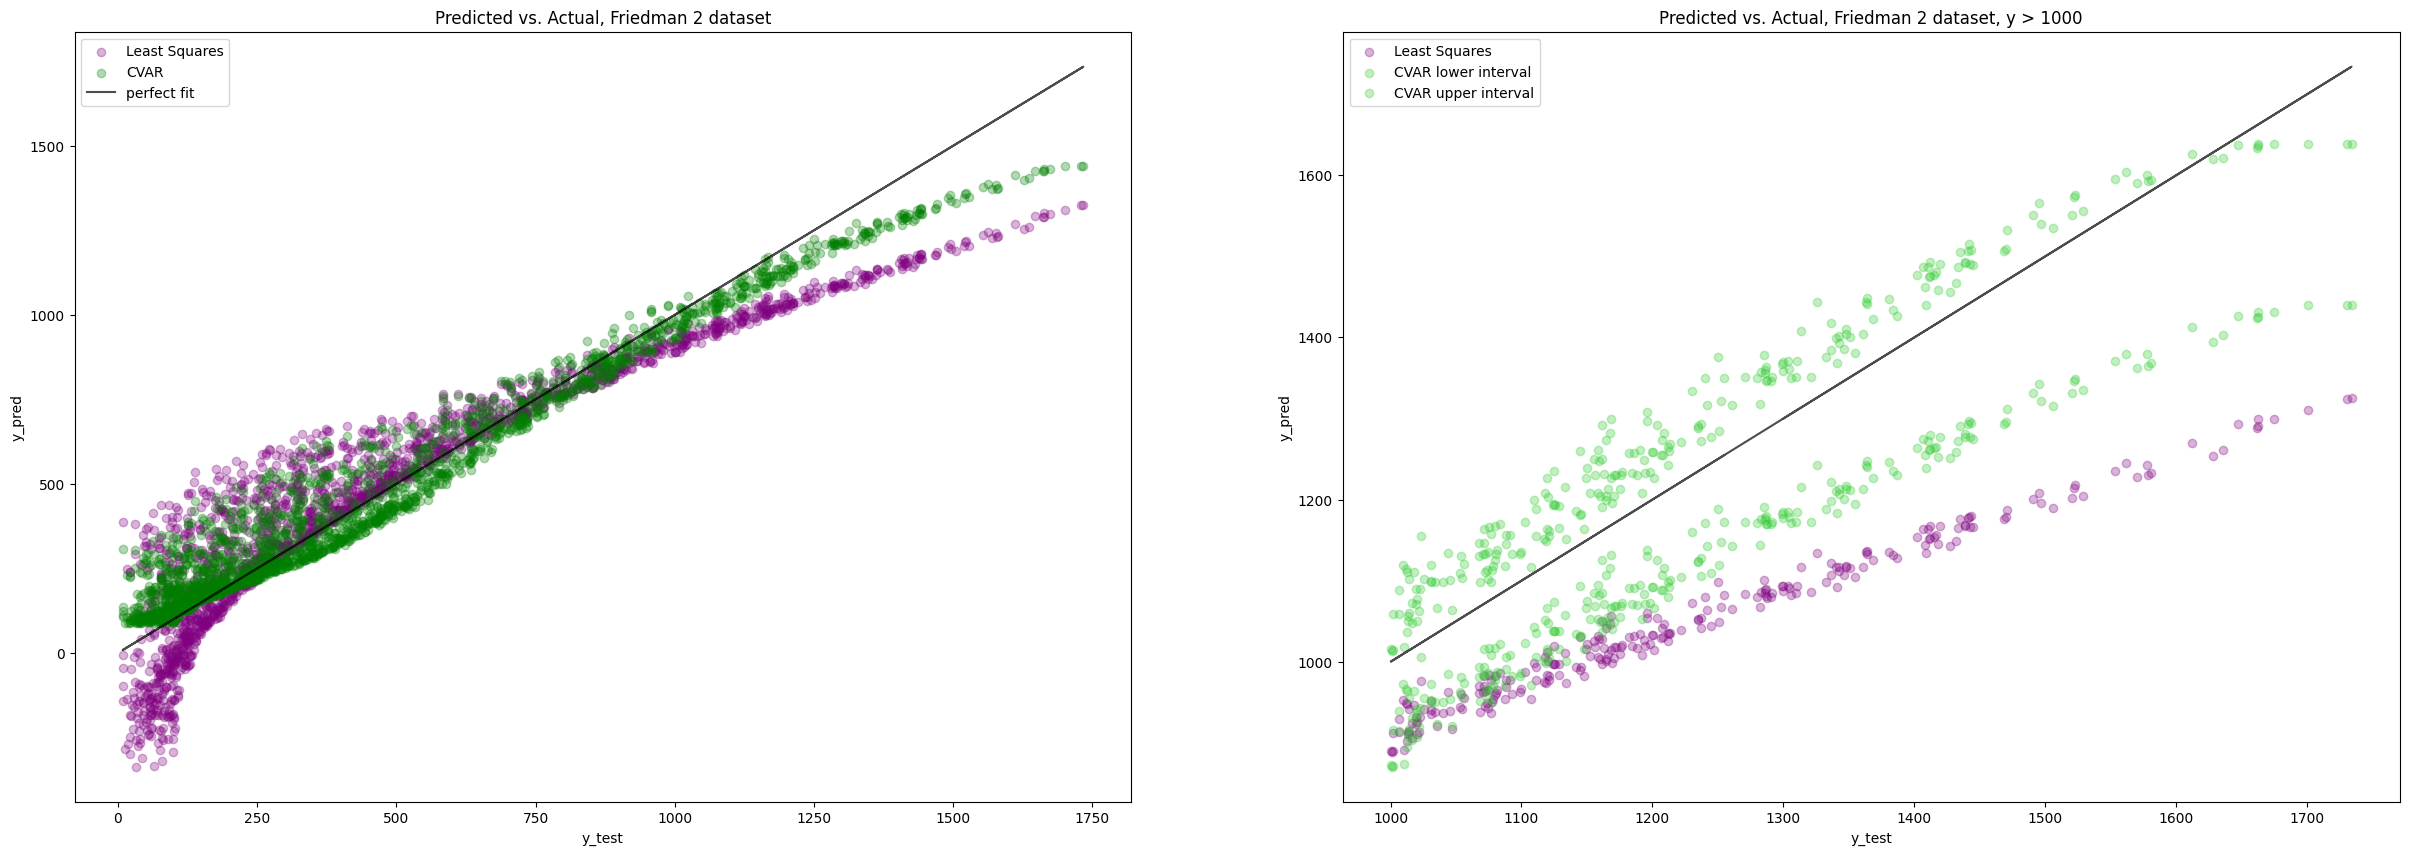

In [7]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
ax[0].scatter(y_test, base_pred, alpha=0.3, color='purple', label='Least Squares')
ax[0].scatter(y_test, va_preds, alpha=0.3, color='green', label='CVAR')
ax[0].plot(y_test, y_test, alpha=0.7, color='k', label='perfect fit')
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('y_pred')
ax[0].set_title('Predicted vs. Actual, Friedman 2 dataset')
ax[0].legend()
zoom = y_test > 1000
ax[1].scatter(y_test[zoom], base_pred[zoom], alpha=0.3, color='purple', label='Least Squares')
ax[1].scatter(y_test[zoom], va_interval[:2000][zoom], alpha=0.3, color='limegreen', label='CVAR lower interval')
ax[1].scatter(y_test[zoom], va_interval[2000:][zoom], alpha=0.3, color='limegreen', label='CVAR upper interval')
ax[1].plot(y_test[zoom], y_test[zoom], alpha=0.7, color='k')
ax[1].set_xlabel('y_test')
ax[1].set_ylabel('y_pred')
ax[1].legend()
ax[1].set_title('Predicted vs. Actual, Friedman 2 dataset, y > 1000')
plt.show()

## Run experiments across various regression algorithms for all three Friedman datasets

In [8]:
# we set m paramaters to 1 and 10
m_parameters = [1, 10]

In [9]:
def run_benchmark(
    types = [1,2,3],
    seeds=range(10),
    n_samples=10000,
    noise_scale=3.0,
):
    rows = []
    print('Running....')
    for typ in types:
        print('Friedman ' + str(typ))
        for seed in seeds:
            res = run_one_scenario(
                typ=typ,
                n_samples=n_samples,
                noise_scale=noise_scale,
                seed=seed,
            )
            for model_name, score in res.items():
                rows.append({
                    "friedman_dataset": typ,
                    "seed": seed,
                    "model": model_name,
                    "rmse": score,
                })

    df = pd.DataFrame(rows)
    summary = (
        df.groupby(["friedman_dataset", "model"])["rmse"]
          .agg(["mean", "std", "count"])
          .reset_index()
          .sort_values(["friedman_dataset", "mean"])
    )
    return df, summary

In [10]:
random.seed(0)
df_runs, df_summary = run_benchmark(types = [1,2,3], n_samples=10000, noise_scale=3.0)

Running....
Friedman 1
Friedman 2
Friedman 3


### Summarise results

In [11]:
for typ in [1,2,3]:
    print('Friedman dataset ' + str(typ))
    df_summ = df_summary[df_summary.friedman_dataset==typ].copy()
    df_summ['calibration']='base'
    df_summ['base_model']=[i.split(' ')[0] for i in df_summ.iloc[:,1].values]
    df_summ.iloc[['CVAP' in row for row in df_summ['model'].values], -2] = [i.split('C')[1] for i in df_summ.iloc[:,1].values if len(i.split(' ')) > 1]
    df_pivot = df_summ.pivot(index='base_model', columns='calibration', values='mean')
    df_pivot_std = df_summ.pivot(index='base_model', columns='calibration', values='std')
    average_values = df_pivot.select_dtypes(include=['number']).mean()
    df_pivot.loc['average'] = average_values
    df_pivot = df_pivot.iloc[:, [-1, 0, 1]]
    df_pivot.columns = ['none', 'CVAR1', 'CVAR10']
    df_pivot.index.name = 'base model'
    display(df_pivot.round(3))

Friedman dataset 1


,none,CVAR1,CVAR10
base model,,,
ElasticNet,4.384,3.888,3.893
GradientBoosting,3.156,3.188,3.203
Lasso,4.357,3.987,3.992
LinearRegression,3.881,3.870,3.876
RandomForest,3.289,3.322,3.335
Ridge,3.881,3.870,3.876
SVR(RBF),3.222,3.256,3.268
average,3.739,3.626,3.635


Friedman dataset 2


,none,CVAR1,CVAR10
base model,,,
ElasticNet,183.180,83.163,84.670
GradientBoosting,15.774,49.805,52.041
Lasso,139.119,83.134,84.634
LinearRegression,139.108,83.186,84.685
RandomForest,6.556,48.226,50.522
Ridge,139.108,83.186,84.686
SVR(RBF),142.966,106.333,106.735
average,109.401,76.719,78.282


Friedman dataset 3


,none,CVAR1,CVAR10
base model,,,
ElasticNet,3.022,3.022,3.022
GradientBoosting,3.024,3.021,3.020
Lasso,3.022,3.022,3.022
LinearRegression,3.013,3.013,3.012
RandomForest,3.108,3.023,3.022
Ridge,3.013,3.013,3.012
SVR(RBF),3.016,3.014,3.013
average,3.031,3.019,3.018


We can see that the CVAR algorithm achieves the lowest average RMSE for each Friedman dataset compared with standard regression algorithms.